In [1]:
import numpy as np
import trimesh
from scipy.stats import special_ortho_group
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from random import sample
import random
from ipywidgets import *
import visualkeras

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.


In [2]:
m = 112

## Perform Generalized Procrustes to Align All Shapes

In [3]:
mesh = trimesh.load_mesh('surf1.ply')
V = np.array(mesh.vertices)
point_list = np.zeros(V.shape)

In [4]:
figures = np.zeros((m, len(point_list), 3))

for k in range(m):
    stl_mesh = trimesh.load_mesh('surf' + str(1 + k) + '.ply')
    figures[k, :, :] = np.array(stl_mesh.vertices)

In [5]:
r = np.random.randint(m)
M = np.zeros(figures[r,:,:].shape)

for k in range(m):
    if k != r: 
        T, V_transformed, d = trimesh.registration.procrustes(figures[k,:,:], figures[r,:,:])
        M += V_transformed
    
M /= ( m - 1 )

for t in range(2):
    M_new = np.zeros(M.shape)
    total_d = []
    for k in range(m):
        T, V_transformed, d = trimesh.registration.procrustes(figures[k,:,:], M)
        total_d.append(d)
        M_new += V_transformed
    M = M_new
    M /= m
    
    if max(total_d) < 0.1:
        print("Converged!")
        break

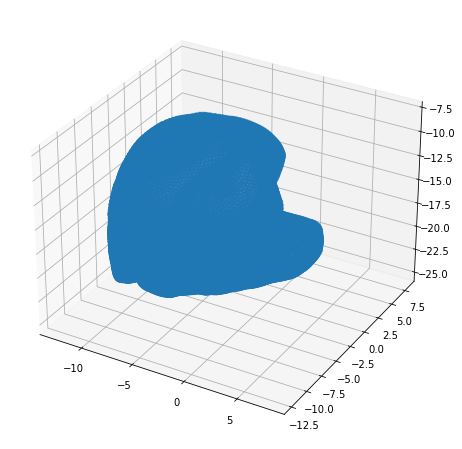

In [6]:
#%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(M[:,0], M[:,1], M[:,2])
plt.show()

In [7]:
for k in range(m):
    T, V_transformed, d = trimesh.registration.procrustes(figures[k,:,:], M)
    figures[k,:,:] = V_transformed

## Voxelize Data

In [8]:
X_min = np.min(np.min(figures[:,:,0])) - 1
Y_min = np.min(np.min(figures[:,:,1])) - 1
Z_min = np.min(np.min(figures[:,:,2])) - 1

figures[:,:,0] = figures[:,:,0] - X_min
figures[:,:,1] = figures[:,:,1] - Y_min
figures[:,:,2] = figures[:,:,2] - Z_min

X_max = np.max(np.max(figures[:,:,0])) + 1
Y_max = np.max(np.max(figures[:,:,1])) + 1
Z_max = np.max(np.max(figures[:,:,2])) + 1

figures[:,:,0] /= X_max
figures[:,:,1] /= Y_max
figures[:,:,2] /= Z_max

In [9]:
mesh = trimesh.load_mesh('surf1.ply')
mesh.vertices = figures[0,:,:]

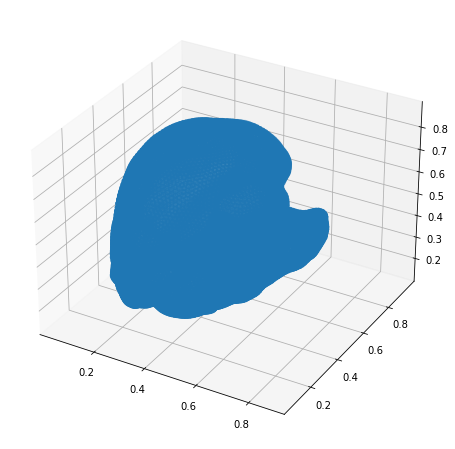

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(mesh.vertices[:,0], mesh.vertices[:,1], mesh.vertices[:,2])
plt.show()

In [11]:
# assumption: mesh resides within [0,1]^3
def dense_voxelize(mesh, num_cells_per_side): 
    
    voxel_cells = np.zeros((num_cells_per_side,num_cells_per_side,num_cells_per_side))
    
    check_in_or_out = trimesh.proximity.ProximityQuery(mesh)
    
    
    diff = 1.0 / num_cells_per_side 

    start = diff / 2
    
    for i in range(num_cells_per_side):
        for j in range(num_cells_per_side):
            for k in range(num_cells_per_side): 
                
                check_point = [start + i*diff, start + j*diff, start + k*diff]
                
                if check_in_or_out.signed_distance([check_point]) >= 0:
                    voxel_cells[i,j,k] = 1
    
    return voxel_cells

In [12]:
voxel_shapes = np.zeros((m,32,32,32))
for k in range(m):
    print("Mesh: ", k)
    stl_mesh = trimesh.load_mesh('surf' + str(1 + k) + '.ply')
    stl_mesh.vertices = figures[k,:,:]
    voxel_shapes[k,:,:,:] = dense_voxelize(stl_mesh, 32)

Mesh:  0
Mesh:  1
Mesh:  2


In [13]:
np.save("voxelized_meshes", voxel_shapes)

In [14]:
voxel1 = voxel_shapes[1,:,:,:]

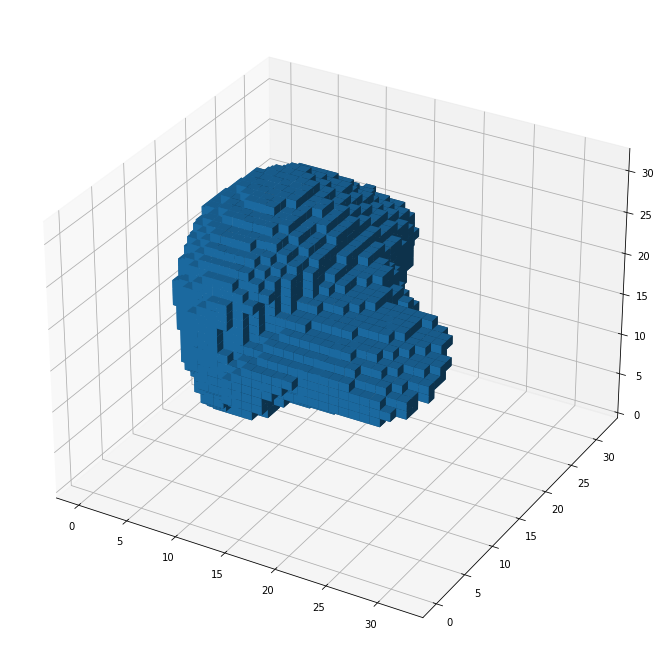

In [15]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.voxels(voxel1)

plt.show()